<h1 id="awda" style="color:white;background:#0087B6;padding:8px;border-radius:8px"> Intel image classification - Transfer learning</h1> 

In this notebook, we will learn how to classify images of Natural Scenes by using transfer learning from a pre-trained network.

### What we will learn 

* Working with image data loader
* Visualizing a single batch of images
* Setting up callbacks
* Transfer learning
    * EfficientNetB0 Feature extraction model
    * EfficientNetB0 Fine tuning model

<h1 id="emdddlogrgs" style="color:white;background:#0087B6;padding:8px;border-radius:8px"> Import libraries </h1>

In [1]:
import numpy as np 
import pandas as pd 
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' ## hide tf warnings
import tensorflow as tf
import matplotlib.pyplot as plt

<h1 id="elogrgs" style="color:white;background:#0087B6;padding:8px;border-radius:8px">Preparing images</h1>
    


### Creating train and test datasets
To create image datasets use`tf.keras.preprocessing.image_dataset_from_directory` function, It generates `tf.data.Dataset` that yields batches of images from the subdirectories like sea, forest, street ,...



In [2]:
IMAGE_SHAPE = (150, 150)
BATCH_SIZE = 32

# Define train and test data path
train_dir = '../input/intel-image-classification/seg_train/seg_train/'
test_dir = '../input/intel-image-classification/seg_test/seg_test/'

print('Training images:')
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                              image_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              label_mode="categorical")

print('Testing images:')
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                              image_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              label_mode="categorical")

Training images:
Found 14034 files belonging to 6 classes.
Testing images:
Found 3000 files belonging to 6 classes.


<h1 id="erljgdgs" style="color:white;background:#0087B6;padding:8px;border-radius:8px"> Take a batch from train data and visualize it </h1>

Use `train_data.take()` to take a single batch and visualize it, `take()` returns a tuple containing images and labels (images, labels)

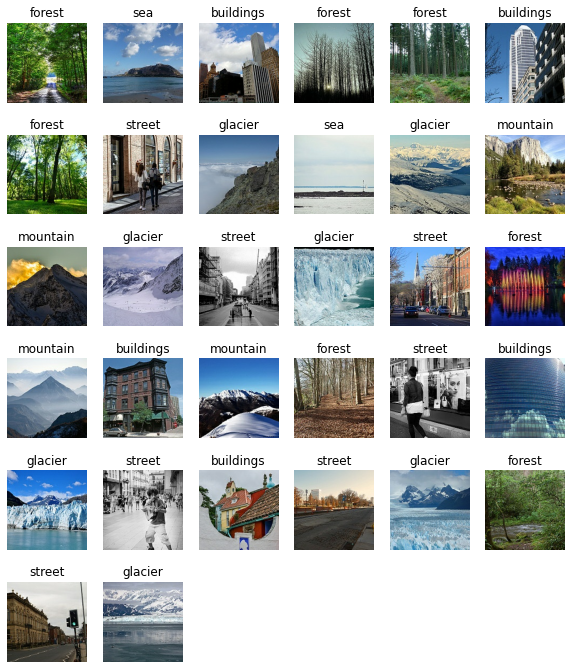

In [3]:
plt.figure(figsize=(10, 12))
class_names = train_data.class_names
for images, labels in train_data.take(1):
    for i in range(32):
        ax = plt.subplot(6, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")

<h1 id="ergdfffggs" style="color:white;background:#0087B6;padding:8px;border-radius:8px"> What is transfer learning ? </h1>

A pre-trained model is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task. You either use the pretrained model as is or use transfer learning to customize this model to a given task.

The intuition behind transfer learning for image classification is that if a model is trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. You can then take advantage of these learned feature maps without having to start from scratch by training a large model on a large dataset.

### In this notebook, we will try two ways to customize a pretrained model:

* **Feature Extraction**: Use the representations learned by a previous network to extract meaningful features from new samples. You simply add a new classifier, which will be trained from scratch, on top of the pretrained model so that you can repurpose the feature maps learned previously for the dataset.

* **Fine-Tuning**: Unfreeze a few of the top layers of a frozen model base and jointly train both the newly-added classifier layers and the last layers of the base model. This allows us to "fine-tune" the higher-order feature representations in the base model in order to make them more relevant for the specific task.

<h1 id="ergdfsdggs" style="color:white;background:#0087B6;padding:8px;border-radius:8px"> Tensorflow callbacks</h1>
A callback is an object that can perform actions at various stages of training (e.g. at the start or end of an epoch, before or after a single batch, etc).

### Checkpoint callback

ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval, so the model or weights can be loaded later to continue the training from the state saved.

In [4]:
# Checkpoint path
CheckpointPath="EfficientNetB0.h5"

CheckpointCallback= tf.keras.callbacks.ModelCheckpoint(
                            filepath=CheckpointPath,
                            verbose=1,
                            save_best_only=True,
                            save_weights_only=False,
                            monitor='val_accuracy',
                            period=1
)

### Learning rate reduction callback
Reduce learning rate when a metric has stopped improving

In [5]:
Learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.5, 
                                             mode='auto',
                                            cooldown=1 )

 ### Early stopping callback
 
 Stop training when a monitored metric has stopped improving.

In [6]:
Early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                                  min_delta=0.001,
                                                  patience = 5,
                                                  verbose = 1,
                                                  restore_best_weights=True)

<h1 id="ergs" style="color:white;background:#0087B6;padding:8px;border-radius:8px">EfficientNetB0 Feature Extraction model </h1>

I'm going to use functional API instead of keras Sequential API.

**What's the difference between functional API and sequential API ?**

The Keras functional API is a way to create models that are more flexible than the tf.keras.Sequential API. The functional API can handle models with non-linear topology, shared layers, and even multiple inputs or outputs.

If you haven't tried the Sequential API before, I recommend you go through the following notebook : [FashionMNIST/ CNN With TensorFlow](https://www.kaggle.com/code/mehrdadsadeghi/fashionmnist-cnn-with-tensorflow-confusionmatrix/notebook) 


In [7]:
# Create base model (load the pre-trained model)
base_model_EfficientNetB0 = tf.keras.applications.EfficientNetB0(include_top=False)

# Freeze the base model (pre-trained patterns aren't update during training)
base_model_EfficientNetB0.trainable = False

# Create inputs 
inputs = tf.keras.layers.Input(shape=(150,150,3), name="input_layer")

# Pass the inputs to the base model
x = base_model_EfficientNetB0(inputs)

# Average pooling the outputs of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Create output activation layer
outputs = tf.keras.layers.Dense(6,activation="softmax", name="output_layer")(x)

# Combine the inputs with the outputs into a model
model_1 = tf.keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
               optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
               metrics=["accuracy"])

# Fit the model and save its history
history_1 = model_1.fit(train_data,
                       epochs=5,
                       steps_per_epoch=len(train_data),
                       validation_data=test_data,
                       validation_steps=len(test_data),
                       callbacks=[
                                  CheckpointCallback,
                                  Early_stopping,
                                  Learning_rate_reduction])

16719872/16705208 [==============================] - 0s 0us/step
Epoch 1/5
439/439 [==============================] - 59s 111ms/step - loss: 0.9774 - accuracy: 0.6936 - val_loss: 0.5478 - val_accuracy: 0.8637

Epoch 00001: val_accuracy improved from -inf to 0.86367, saving model to EfficientNetB0.h5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/5
439/439 [==============================] - 17s 38ms/step - loss: 0.4526 - accuracy: 0.8752 - val_loss: 0.3806 - val_accuracy: 0.8867

Epoch 00002: val_accuracy improved from 0.86367 to 0.88667, saving model to EfficientNetB0.h5
Epoch 3/5
439/439 [==============================] - 17s 38ms/step - loss: 0.3529 - accuracy: 0.8888 - val_loss: 0.3244 - val_accuracy: 0.8987

Epoch 00003: val_accuracy improved from 0.88667 to 0.89867, saving model to EfficientNetB0.h5
Epoch 4/5
439/439 [==============================] - 16s 35ms/step - loss: 0.3107 - accuracy: 0.8970 - val_loss: 0.2973 - val_accuracy: 0.9043

Epoch 00004: val_accuracy improved from 0.89867 to 0.90433, saving model to EfficientNetB0.h5
Epoch 5/5
439/439 [==============================] - 17s 37ms/step - loss: 0.2865 - accuracy: 0.9041 - val_loss: 0.2802 - val_accuracy: 0.9067

Epoch 00005: val_accuracy improved from 0.90433 to 0.90667, saving model to EfficientNetB0.h5


### Loss curves

In [8]:
#Create a function to plot loss curves
import matplotlib.pyplot as plt
def plot_loss_curves(history):
    plt.plot(history.history["loss"], label="training_loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    plt.figure()
    plt.plot(history.history["accuracy"], label="training_accuracy")
    plt.plot(history.history["val_accuracy"], label="val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

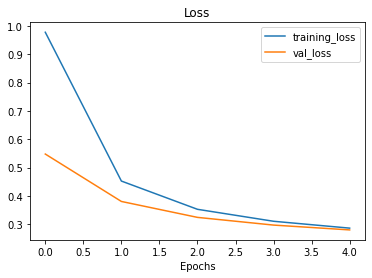

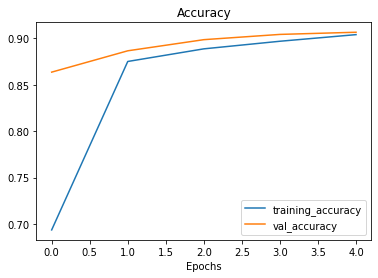

In [9]:
plot_loss_curves(history_1)

<h1 id="ergffseqs" style="color:white;background:#0087B6;padding:8px;border-radius:8px"> Fine tuning </h1>

I will unfreeze the last 15 layers of the base model and continue training for 5 more epochs, you can also unfreeze less or more layers and let me know if you achieved better score.

## EfficientNetB0 Fine tuning

In [10]:
# Unfreeze all layers of the base model
base_model_EfficientNetB0.trainable= True

# Freeze all layers except the last 15 layer
for layer in base_model_EfficientNetB0.layers[:-15]:
    layer.trainable=False

# Recompile
model_1.compile(loss="categorical_crossentropy",
               optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
               metrics=["accuracy"])


### Fit the model 

In [11]:
#Fine tune for another 5 epochs
initial_epochs= 5
fine_tune_epochs=initial_epochs + 5

hisotory_2 = model_1.fit(train_data,
                                       epochs=fine_tune_epochs,
                                       validation_data=test_data,
                                       validation_steps=len(test_data),
                                       initial_epoch=history_1.epoch[-1],
                                       callbacks=[
                                  CheckpointCallback,
                                  Early_stopping,
                                  Learning_rate_reduction])

Epoch 5/10
439/439 [==============================] - 24s 42ms/step - loss: 0.3115 - accuracy: 0.8947 - val_loss: 0.2259 - val_accuracy: 0.9187

Epoch 00005: val_accuracy improved from 0.90667 to 0.91867, saving model to EfficientNetB0.h5
Epoch 6/10
439/439 [==============================] - 17s 39ms/step - loss: 0.2249 - accuracy: 0.9197 - val_loss: 0.2072 - val_accuracy: 0.9250

Epoch 00006: val_accuracy improved from 0.91867 to 0.92500, saving model to EfficientNetB0.h5
Epoch 7/10
439/439 [==============================] - 16s 36ms/step - loss: 0.1902 - accuracy: 0.9318 - val_loss: 0.2013 - val_accuracy: 0.9247

Epoch 00007: val_accuracy did not improve from 0.92500
Epoch 8/10
439/439 [==============================] - 17s 39ms/step - loss: 0.1663 - accuracy: 0.9402 - val_loss: 0.1986 - val_accuracy: 0.9260

Epoch 00008: val_accuracy improved from 0.92500 to 0.92600, saving model to EfficientNetB0.h5
Epoch 9/10
439/439 [==============================] - 17s 39ms/step - loss: 0.1459 

#### The model achieved 93% accuracy after fine tuning

### Fine tuning results

In [12]:
#compare histories
def compare_histories(history,new_history,initial_epochs):
    loss=history.history["loss"]
    val_loss=history.history["val_loss"]
    
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    epochs=range(len(history.history["loss"])+len(new_history.history["loss"]))
    
    total_acc= accuracy+ new_history.history["accuracy"]
    total_loss=loss+ new_history.history["loss"]
    
    total_val_acc= val_accuracy + new_history.history["val_accuracy"]
    total_val_loss=val_loss+ new_history.history["val_loss"]

    plt.figure(figsize=(8,8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc ,label="Training Accuracy")
    plt.plot(total_val_acc, label="Val Accuracy")
    plt.plot([initial_epochs-1,initial_epochs-1],plt.ylim(), label="Start Fine Tuning")
    plt.title("Training and Validation accuracy")
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label="Training_loss")
    plt.plot(total_val_loss, label="Val_loss")
    plt.plot([initial_epochs-1,initial_epochs-1],plt.ylim(), label="Start Fine Tuning")
    plt.title("Training and Validation Loss")
    plt.legend()
    

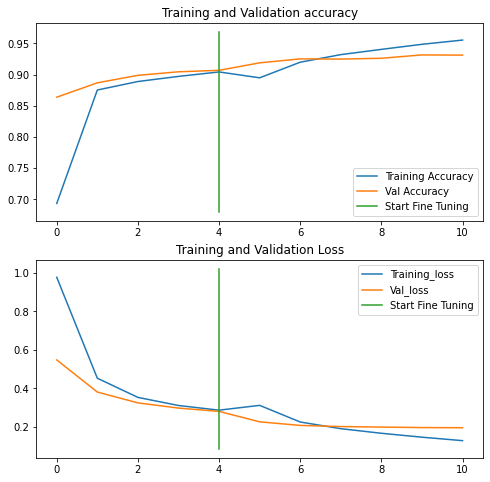

In [13]:
compare_histories(history_1,hisotory_2,5)